# 量子エラー訂正

> このLabは2023年Challenge Spring Lab4 を基に作成しました。

量子コンピューターでは、物理的な量子ビットがノイズの影響を受けやすいためエラー訂正が重要です。これは回路を実行すると常に小さな確率でエラーが発生することを意味します。  
エラー訂正は、発生したエラーを修正することでこの小さな確率の事象に対処し、最終的に正しい結果を得ることを可能にします。

In [1]:
import qiskit
qiskit.__version__

'1.4.2'

In [2]:
# Importing all the parts we will need.
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram

import math
pi = math.pi

## 古典エラー訂正

そもそも、なぜエラー訂正が生まれたのでしょうか？

例えば、電波が悪い時に電話で誰かと話すシーンを考えてみてください。せっかくはっきり話そうとしているのに、メッセージが変わってしまったり、台無しになってしまったりすることがあります。「フレッドとのランチを金曜の予定に入れよう(Let's put lunch with Fred)」が、「金曜にフレッドを殴ろう(Let's punch Fred)」に変わってしまうのです。フレッドの週末は一気に悪くなってしまいました。

メッセージを送るとき、たとえビットのような単純なものであっても、常に小さなエラーが発生する可能性があります。1ビットのデータを有線で送信する場合、ビットが反転してしまい、受信者が「0」の代わりに「1」を受け取るという可能性が少しはあるかもしれません。ケーブルが古く、腐食している場合、このようなことが起こりやすくなります。また、データを保存する際にも、CDに傷がつくのと同じようなことが起こる可能性があります。最悪の場合、プロセッサーで計算中にエラーが発生することもあります。

このようなエラーの可能性は、古典情報の問題として知られています。

ビットが誤って反転する（AKAエラーが発生する）確率を10％とします。これは、1ビットのデータを送信するごとに、1/10の確率で受信したビットが正しくないことを意味します。`0`のメッセージを10回送信しても、受信したメッセージは「`0001000000`」と表示されるかもしれないのです。これが問題なのはもうお分かりですね。

最も簡単な解決策の1つは繰り返すことです。ビットデータ`1`は`111`とエンコードされ、同様に`0`は`000`とエンコードされます。各ビットのデータは、1ビットではなく3ビットでエンコードされます。

これが何の役に立つのでしょう？

もし今、`000`を送信してエラーが発生した場合、受信者には`001`と表示されるかもしれません。受信者は`000`か`111`のどちらかが送られてくるはずだと知っているので、おそらく送られたのは`000`で、1ビットだけ反転したのだろうと推測することができます。こうすればエラーが修正できます！

しかし、複数のエラーが発生した場合はどうでしょう？メッセージは`011`に変わり、受信者は私たちが`111`を送るつもりだったと思い込んでしまいます。これは本当のエラーです！  
繰り返しを使うことで、そのようなことが起こる可能性を減らすことはできますが、ゼロにするわけではありません。では、具体的にどれくらいの確率でエラーを減らすことができるのでしょうか？調べてみましょう！

以下のコードで、エラーがどのように変化するか、自分で確率を求めることができます。

In [3]:
# Probability for a 000 message to contain one error:
p1 = 0.10

# Calculating the probability of a message containing 2 or 3 errors:
p3 = 3 * p1 * p1 * (1 - p1) + p1 * p1 * p1

print("Percent chance the 000 message has one error: {}".format(p1 * 100))
print("Percent chance the 000 message has 2 or 3 errors: {:.4f}".format(p3 * 100))

Percent chance the 000 message has one error: 10.0
Percent chance the 000 message has 2 or 3 errors: 2.8000


反復を用いることで、メッセージを台無しにするエラー（2ビット以上が反転した場合）の可能性を2.8％にまで減らすことができます。これは、1ビットしか使わない場合の10％よりもずっと良い結果です。しかし、これは10％という作り出したエラーに過ぎません。エラーの割合`p1`を変えて、2つ以上のエラーが発生する確率にどのような影響を与えるか見てみましょう。

繰り返しがどのように役立つかを知っている私たちは、上のメッセージを1ビットを3ビットに「エンコード」する簡単なプログラムを実装することができます。そして、3ビットを1ビットに戻す、つまり「デコード」するプログラムも作れます。

### Exercise: 3量子ビットデコード回路の実装
````{admonition} Exercise
入門編として、量子ビット0、1、2を使った3ビットの状態を、以下のルールに従って量子ビット4の1ビットにデコードする「デコーダー」を作ってみましょう。

- 000->0
- 001->0
- 010->0
- 100->0
- 111->1
- 110->1
- 101->1
- 011->1

_ヒント: ビットを反転させるだけなので、位相を導入するようなゲートは必要ありません。必要なのは**基本ゲート**だけです。_
    
```python
# Creating a simple decoder for the classical case
def create_decoder(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # Expect a bit being encoded in the first 3 qubits and decode it into the 4th qubit
    # Make sure values of the first 3 qubit stays the same

    qc = QuantumCircuit(qr, cr)
    q0, q1, q2, q3 = qr
    (c0,) = cr

    ####### your code goes here #######

    return qc

```
````

In [4]:
def create_decoder(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # Expect a bit being encoded in the first 3 qubits and decode it into the 4th qubit
    # Make sure values of the first 3 qubit stays the same

    qc = QuantumCircuit(qr, cr)
    q0, q1, q2, q3 = qr
    (c0,) = cr

    ####### your code goes here #######
    qc.ccx(q0, q1, q3)
    qc.ccx(q1, q2, q3)
    qc.ccx(q2, q0, q3)

    return qc

```{admonition} 解説
:class: tip
Exercise1は **エンコードされた3つの量子ビットの内、「0」と「1」の多い状態をデコードの結果** として4つ目の量子ビットに反映する問題です。

これは単純に考えるならば実際に量子ビットを測定し、その結果の「0」の個数が個数が多ければ0、「1」の個数が多ければ1とすれば良いわけですが、量子ビットは一度測定してしまうと重ね合わせ状態が壊れてしまうため問題文上の「最初の3つのqubitの状態は同じままであること」という条件を満たせなくなります。
そこで制御ビットの量子状態を変化させない複数量子ビットゲートを使用することを検討します。ターゲットビットの「0」と「1」を入れ替えるという意味で使えそうな複数量子ビットゲートには、制御xゲート(cxゲート)とToffoliゲート(ccxゲート)の2つがあります。まず制御xゲートの場合、つまりデコード対象の各量子ビットの状態が「1」の時、デコード結果の量子ビットの状態を入れ替えるため、

|  デコード対象  |  デコード結果  |
| -------------- | -------------- |
|      000       |       0        |
|      001       |       1        |
|      010       |       1        |
|      100       |       1        |
|      111       |       1        |
|      110       |       0        |
|      101       |       0        |
|      011       |       0        |

といった結果になります。(デコード対象に奇数回「1」があればデコード結果は「1」、偶数回「1」があればデコード結果は「0」)これはデコードできていません。
次にToffoliゲートの場合、3つの量子ビットの中から2つの量子ビットを取り出し、共に「1」であった場合デコード結果の量子ビットの状態を入れ替えるため、

|  デコード対象  |  デコード結果  |
| -------------- | -------------- |
|      000       |       0        |
|      001       |       0        |
|      010       |       0        |
|      100       |       0        |
|      111       |       1        |
|      110       |       1        |
|      101       |       1        |
|      011       |       1        |

といった結果になります。これは今回求めたいデコード結果に相当しており、こちらを解として記載しています。
```

以下のコードを使用すれば、作成したデコーダーで1をエンコードした場合のデコードの様子を確認することができます。

いろいろな入力（エラーも含む）で遊んでみて、エラー訂正回路がどのような動作をするのか試してみましょう。

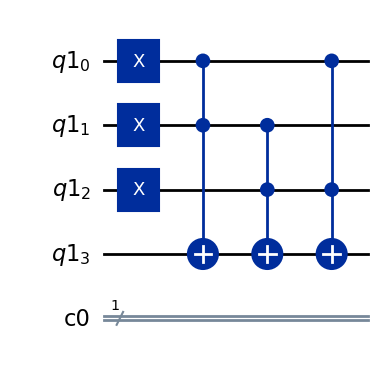

In [5]:
# We expect a bit being encoded in the first 3 qubits and decode it into the 4th qubit
qr = QuantumRegister(4)
cr = ClassicalRegister(1)

q0, q1, q2, q3 = qr

# To encode a 1. Change them to test the other encodings.
encoder = QuantumCircuit(qr, cr)
encoder.x(q0)
encoder.x(q1)
encoder.x(q2)

decoder = create_decoder(qr, cr)
qc1 = encoder.compose(decoder)

qc1.draw("mpl")

## 量子エラー訂正

古典の場合、このような誤り訂正符号を持つことは、ビットを数回繰り返すだけなので比較的簡単です。  
もちろん、もっと複雑な符号も存在しますが、最終的にはすべての符号が情報を繰り返すことによってある種の冗長性を持つことになります。

しかし量子の場合、以下の2つの理由から**ビットの繰り返しを実現することができません**。

1. 量子ビットのコピーは原理的に不可能（複製不可能定理）

2. 量子ビットを測定すると、その状態が崩れてしまうのでエンタングルした量子ビットの扱いが難しい

これは少しがっかりするような話ですが、それでもエラー訂正は可能です。  
しかし、情報を保存するための量子ビットが必要なだけでなく、いわゆる**スタビライザー**として使用する、追加のアンシラ（補助）量子ビットが必要です。  
スタビライザーが作用する補助量子ビット自体は量子状態を変化させることはありませんが、それ故にエラーが発生した場合のヒントを与えてくれます。

以降は2種類の量子ビットを使用します。エンコードに使用するものと、スタビライザーに使用するものです。

## ビット反転反復符号の実装

In [6]:
# Setup a base quantum circuit for our experiments
encoding = QuantumRegister(3)
stabilizer = QuantumRegister(2)

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# Results of the encoding
results = ClassicalRegister(3)

result_b0, result_b1, result_b2 = results

# For measuring the stabilizer
syndrome = ClassicalRegister(2)

syndrome_b0, syndrome_b1 = syndrome

# The actual qubit which is encoded
state = encoding[0]

# The ancillas used for encoding the state
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

### 量子ビットの初期化

量子状態をエラーから守るために、最初に備えておく必要があります。
一般に状態$$|\Psi_0\rangle \rightarrow |\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$$を作り出すことが可能です。
以下の回路で状態$$|\Psi_1\rangle = |1\rangle$$を準備します。

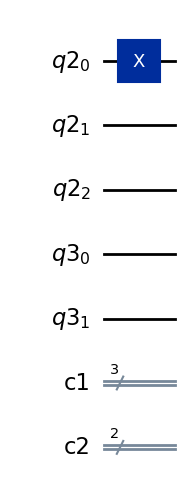

In [7]:
initial_state = initialize_circuit()

initial_state.x(encoding[0])

initial_state.draw(output="mpl")

### 量子ビットのエンコード

古典の場合と同様に初期化された量子ビットを保存するために繰り返しを用いたくなります。  
状態 $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$ から $ (\alpha |000\rangle + \beta |111\rangle)$ へのマッピングをエンコーディング$U_{en}|\Psi_0\rangle$で実行してみましょう。

この状態はエンタングルした状態で、1つの量子ビットが測定されると他の2つの量子ビットの出力も確定する性質を持ちます。  
初めの1量子ビット状態から3量子ビットのエンタングル状態を作るためにCXゲートを使います。

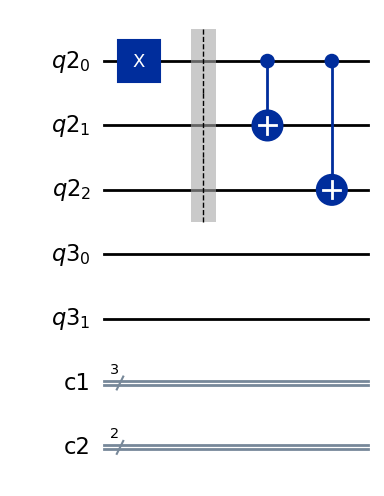

In [8]:
# Encoding using bit flip code
def encode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc


# The circuit encoding our qubit
encoding_circuit = encode_bit_flip(initialize_circuit(), state, ancillas)

# The circuit including all parts so far
complete_circuit = initial_state.compose(encoding_circuit)
complete_circuit.draw(output="mpl")

### デコード回路の準備

元の状態へデコードするために、逆の操作を実行するデコーダーを構築しなければなりません。  
つまり$ (\alpha |000\rangle + \beta |111\rangle)$を$|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$ へマッピングするデコーダー$U_{de}|\Psi_0\rangle$です。

全く逆の操作なので、エンコーダーを逆転（$U_{de} = U_{en}^\dagger$）させればよいです。

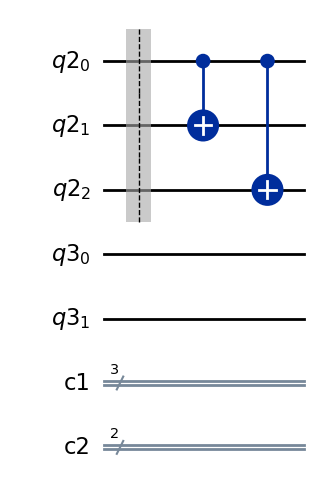

In [9]:
# Decoding (doing the reverse)
def decode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc


decoding_circuit = decode_bit_flip(initialize_circuit(), state, ancillas)

decoding_circuit.draw(output="mpl")

### スタビライザーの測定

$A$をターゲット、$B$をソースとするCXゲートを用いることで、量子ビット$A$を別の量子ビット$B$とエンタングルさせることができることを先ほど確認しました（$B$がすでに重ね合わせやエンタングル状態にある場合）。  
その後、$A$をターゲットとして、$B$（あるいは、$A$と完全にエンタングルした別の量子ビット）をソースとする別のCXゲートを使うことで、再びエンタングルメントを解くことができます。

スタビライザーを測定して、発生した潜在的なエラーを把握したいので、スタビライザーが状態をエンコードする量子ビットとエンタングルしていないことが重要です。  
この事実から、各スタビライザーに偶数個のCXゲートを適用する必要があることは明らかです。スタビライザーを使ってビット反転エラーが発生したかどうか、そして3つのエンコーディング量子ビットのうちどの量子ビットで発生したかを測定する必要があります。

#### Exercise: スタビライザーを利用したエンコード時のエラー検知
````{admonition} Exercise
測定から単一ビット反転エラーを検出できるように、シンドロームビットを計算してください。  
シンドロームビットを測定し、スタビライザー量子ビットを`0`状態にリセットするコードを用意しました。

さまざまな方法があるので、できるだけ単純な符号化でスタビライザーを手に入れましょう。

`00` -> エラーなし 

`01` -> 量子ビット0（1番目の量子ビット）にエラーあり

`10` -> 量子ビット1（2番目の量子ビット）にエラーあり

`11` -> 量子ビット2（3番目の量子ビット）にエラーあり

*ヒント：3つのエンコーディング量子ビットは完全に相関しているはずですが、もしそうでない場合、そのうちの1つにビット反転エラーが発生しています。*
    
```python
# Add functions such that the classical bits can be used to see which qubit is flipped in the case a single qubit is flipped.
# Use 2 classical bits for it.
# 0 = 00 = no qubit flipped
# 1 = 01 = first qubit (qubit 0) flipped
# 2 = 10 second qubit (qubit 1) flipped
# 3 = 11 = third qubit (qubit 2) flipped
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    ####### your code goes here #######

    ####### don't edit the code below #######
    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.x(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.x(stabilizer_q1)

    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)

complete_circuit = initial_state.compose(encoding_circuit).compose(syndrome_circuit)
complete_circuit.draw("mpl")

```
````

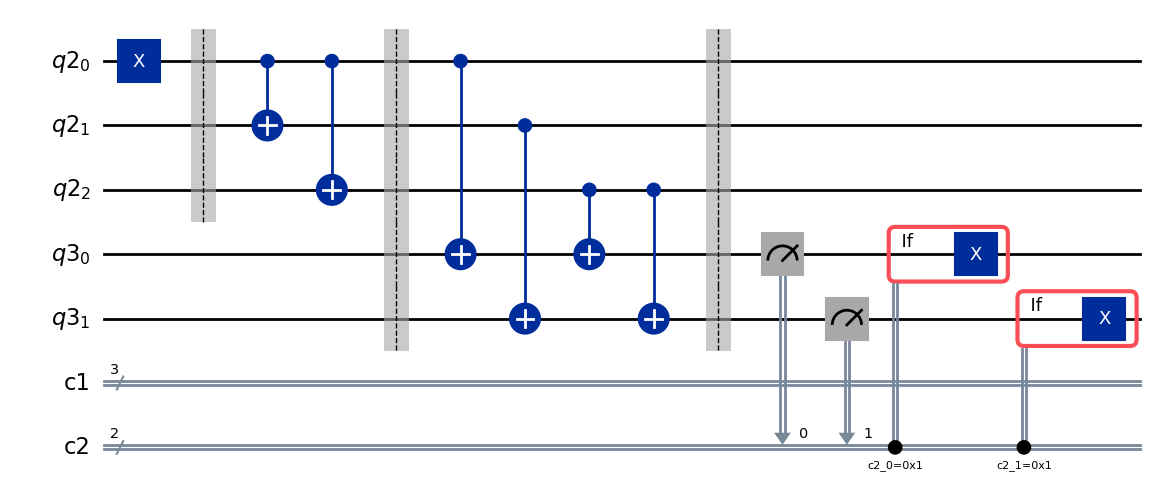

In [10]:
# Add functions such that the classical bits can be used to see which qubit is flipped in the case a single qubit is flipped.
# Use 2 classical bits for it.
# 0 = 00 = no qubit flipped
# 1 = 01 = first qubit (qubit 0) flipped
# 2 = 10 second qubit (qubit 1) flipped
# 3 = 11 = third qubit (qubit 2) flipped
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    ####### your code goes here #######
    qc.cx(encoding_q0, stabilizer_q0)
    qc.cx(encoding_q1, stabilizer_q1)
    qc.cx(encoding_q2, stabilizer_q0)
    qc.cx(encoding_q2, stabilizer_q1)

    ####### don't edit the code below #######
    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.x(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.x(stabilizer_q1)

    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)

complete_circuit = initial_state.compose(encoding_circuit).compose(syndrome_circuit)
complete_circuit.draw("mpl")

```{admonition} 解説
:class: tip
Exercise2は、Exercise1でデコードされる3つの量子ビットをエンタングルメントによるエンコードで作成したとき、そのエンコード後の量子ビットにエラーが生じているかをスタビライザーを使用して検証する問題です。

エンコードした3つの量子ビットは、仮にエラーが無ければ1番目の量子ビット(encoding_q0)に依存しており、encoding_q0が「0」ならば、「000」、「1」ならば「111」となります。つまり考えるべき結果は「000」または「111」の2パターンだけになります。
また、2量子ビット以上のエラーについて考えなくていいのかという点については、2量子ビット以上のエラーが生じてしまうと別の値として解釈することになり正しくデコードできないため、今回の問いとしては考えなくて問題ありません。

以上のことを踏まえると、各エンコード対象の量子ビットと、エラーの状態によって反転しているスタビライザーの間でcxゲートを適用すれば良いです。表にまとめると、下の表のようになります。

|  スタビライザーの値  |        意味         |                   操作                   |
| -------------------- | ------------------- | ---------------------------------------- |
|          00          |     エラー無し      |  |
|          01          | 量子ビット0がエラー |  量子ビット0とスタビライザー0にcxゲート  |
|          10          | 量子ビット1がエラー |  量子ビット1とスタビライザー1にcxゲート  |
|          11          | 量子ビット2がエラー | 量子ビット2とスタビライザー0,1にcxゲート |

（上記が正しいことは「000」の場合を考えると想像しやすいかと思います。）
```

以下のExercise2用のgraderはチャレンジ期間外では起動しないためコメントアウトします。

### エラー訂正

これでスタビライザーを構築し、それを測定することでエラーシンドロームを取得できるようになりました。  
もちろん、エラーが発生したことを示すだけでなく、エラーの修正もできるようにしたいです。

そこで Dynamic Circuit の機能を使ってシンドロームの測定値を用いて、潜在的なエラーを修正することにします。古典のケースと同様に、最大でも1つのエラーしか修正できません。それ以上のエラーを修正したい場合は、5つのエンコード量子ビット以上の長いコードが必要です。

上記のようにうまい方法のシンドローム測定を選んだので、1つのエラーの場合、どの量子ビットが反転しているかが正確に分かるので、エラーを修正するのは非常に簡単です。

#### Exercise: エンコード時のエラー修正
````{admonition} Exercise

測定されたシンドロームに応じてエラーを修正してください。
    
```python
# Correct the errors, remember how we encoded the errors above!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    ####### your code goes here #######

    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
)
complete_circuit.draw(output="mpl")

```
````

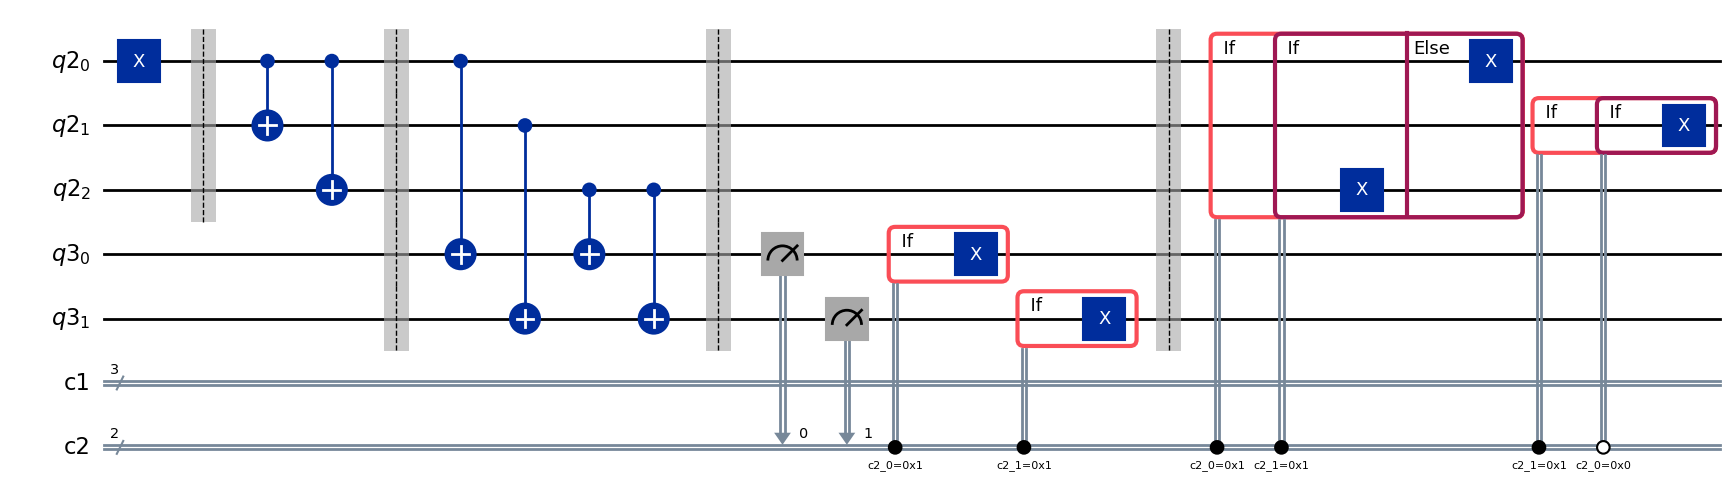

In [11]:
# Correct the errors, remember how we encoded the errors above!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    ####### your code goes here #######
    syndrome_b0, syndrome_b1 = syndrome
    with qc.if_test((syndrome_b0, 1)):
        with qc.if_test((syndrome_b1, 1)) as else_:
            qc.x(encoding_q2)
        with else_:
            qc.x(encoding_q0)
    with qc.if_test((syndrome_b1, 1)):
        with qc.if_test((syndrome_b0, 0)):
            qc.x(encoding_q1)
			
    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
)
complete_circuit.draw(output="mpl")

```{admonition} 解説
:class: tip
Exercise3は、エンコードした3つの量子ビットからエラーを取り除く問題です。

Exercise2の結果から、エラーとなっている部分は以下の表のようになります。

|  スタビライザーの値  |        意味         |
| -------------------- | ------------------- |
|          00          |     エラー無し      |
|          01          | 量子ビット0がエラー |
|          10          | 量子ビット1がエラー |
|          11          | 量子ビット2がエラー |

スタビライザーを適用した際の結果に応じて、エラーとなっているの量子ビットにxゲートを適用すれば問題としては完了です。
```

あとは、エンコード量子ビットを測定するのみです。測定前にデコーダー回路を適用して、初期状態を復元します。

もし、何もエラーがなく完璧に動作するのであれば、最初の量子ビットを測定するだけでよいのですが、必ずしもそうではないので、すべての量子ビットを測定して、何か悪いことが起きていないかどうかを確認します。

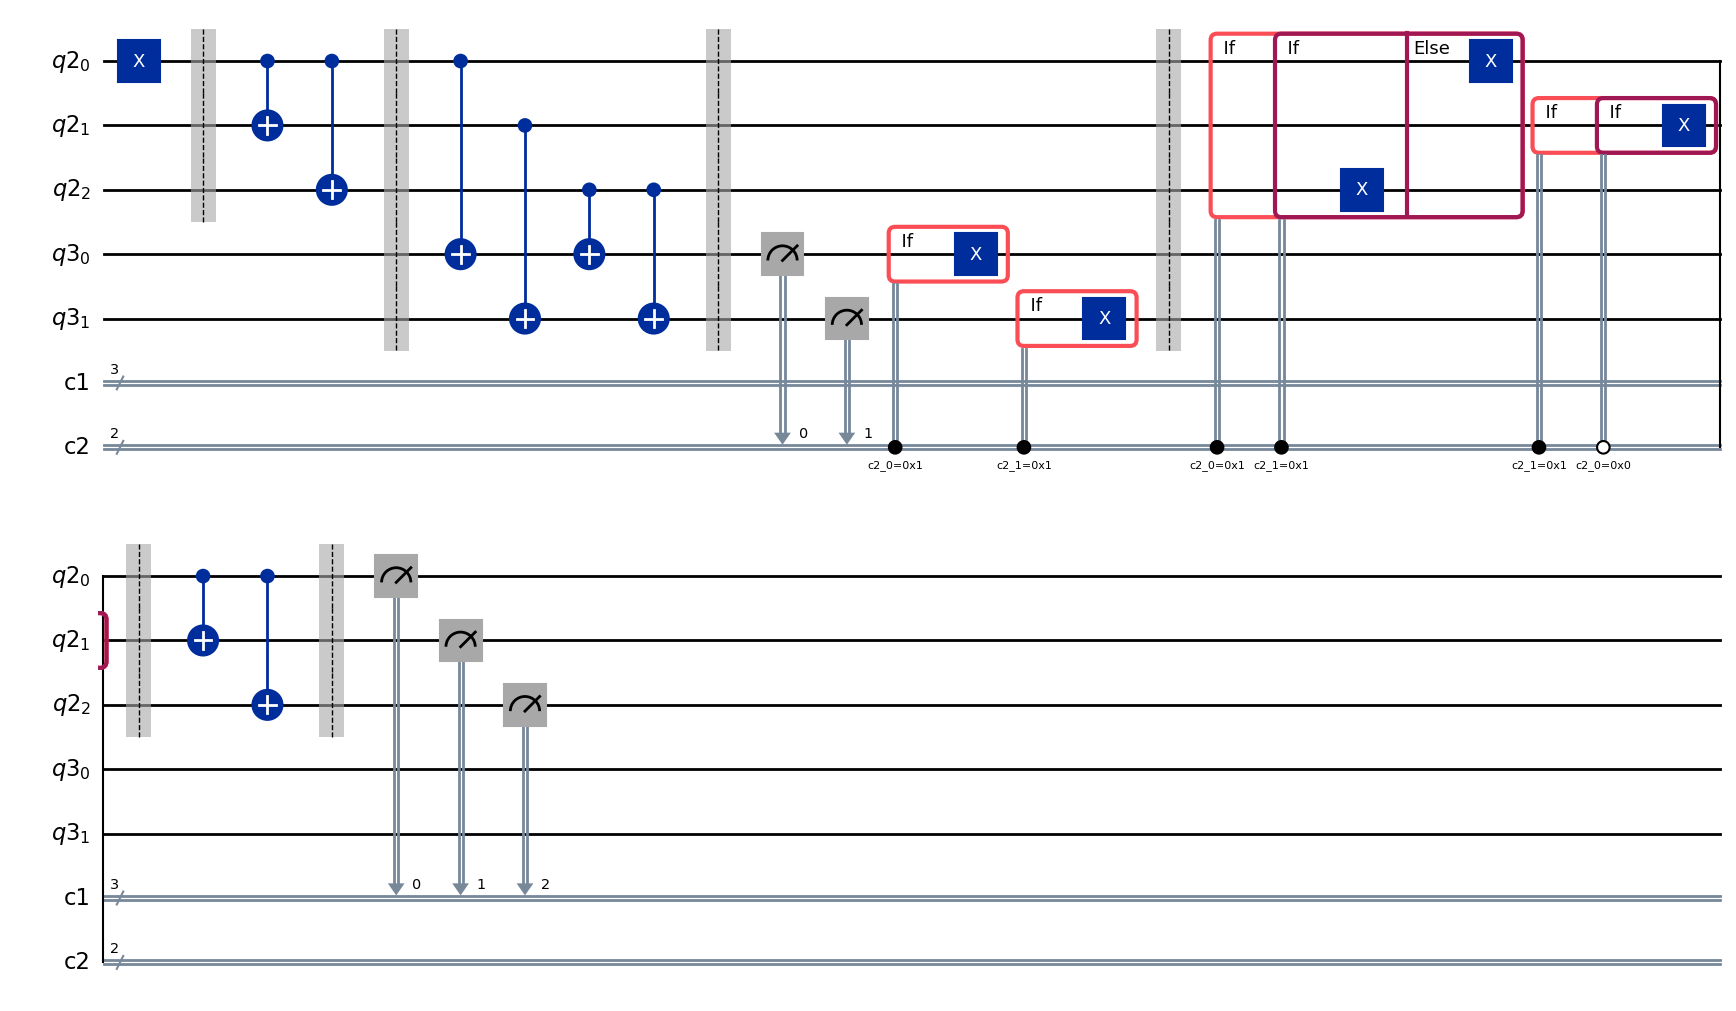

In [12]:
def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")

### テストの準備
 
これですべてが揃ったので、正しい出力が得られるかどうかをテストすることができます。

実装が正しいことを確認するために、エラーなしで最初のテストを行います。

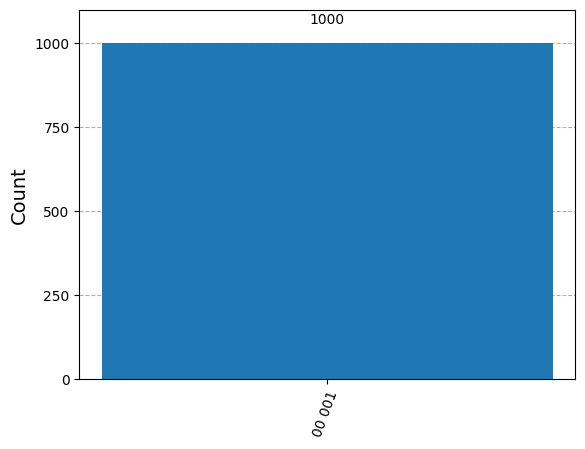

In [13]:
# We first choose a simulator as our backend without any noise
backend = QasmSimulator()
# We run the simulation and get the counts
counts = backend.run(complete_circuit, shots=1000).result().get_counts()
# And now we plot a histogram to see the possible outcomes and corresponding probabilities
plot_histogram(counts)

正しい結果が得られていることがわかります（初期量子ビットを1の状態で初期化したので、`00 001`が得られるはずです）。

エンコードに使用した他の量子ビットは、予想通り処理後`0`の状態になっているのがわかりますね。


さて、この回路がノイズなしで動作することがわかったので、ノイズを追加してみましょう！

そのために、ノイズを含むibm_manilaバックエンドをシミュレートするシミュレータを使用します：

*注：このバックエンドはレイアウトが単純なので選びました。レイアウトについては、後ほど詳しく見ていきます。

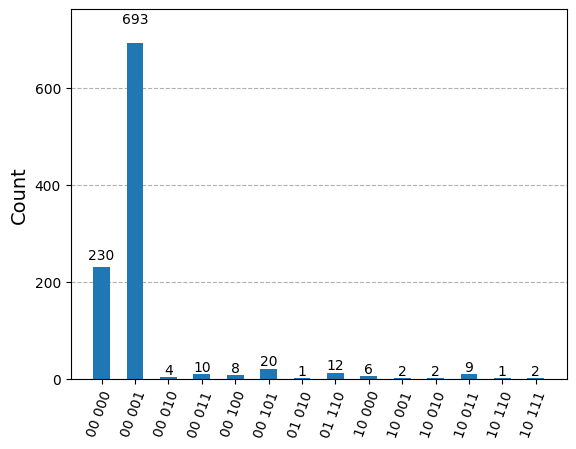

In [14]:
# We choose a simulator for Manila a 5 qubit device, includes errors
backend = FakeManilaV2()
# We run the simulation and get the counts
counts = backend.run(complete_circuit, shots=1000).result().get_counts()
# We plot a histogram to see the possible outcomes and corresponding probabilities
plot_histogram(counts)

間違った結果も出ますが、全体としてはほとんどの結果が正しいです。これは良い兆候であり、ノイズがあっても我々のコードが動作することを意味します。

しかし、エラー訂正なしの場合との比較がないのでこのスキームの良さはわかりません。なのでエラー訂正のステップがない場合どの程度の性能があるのかを見てみましょう：

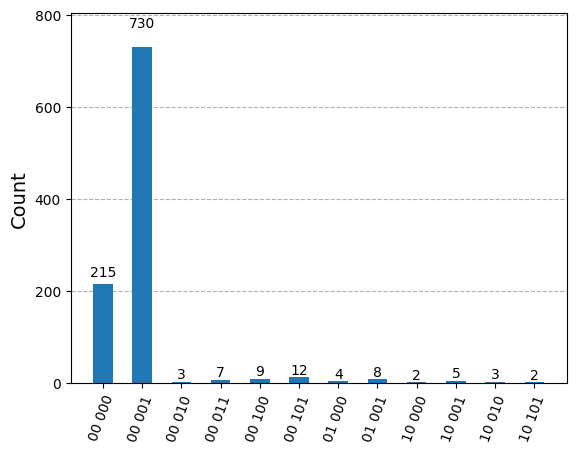

In [15]:
qc3 = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)


# We choose a again FakeManila
backend = FakeManilaV2()
# let the simulation run
counts = backend.run(qc3, shots=1000).result().get_counts()
# and plot our results
plot_histogram(counts)

結果はほぼ同じか、あるいは若干悪くなっていることがわかります。これはエンコード量子ビットを作成後、使用していないためです。  
通常量子ビットを使って計算をすると、何らかのエラーが生じますが、今回はそのようなことはありません。

一方、エラー訂正の部分は、時間のかかる演算を行うため、エラーが発生する可能性があります。
テスト目的に、制御された方法でエラーを発生させる回路を作成してみましょう。
- 修正対象であるビット反転エラーを導入する
- 3エンコード量子ビットのエラーが互いに独立であるようにする
- エラーが発生する確率を選択できるようにする
- 入力はパーセンテージで、出力はその確率でエラーを発生させる回路にする

#### Excersise: 任意のノイズを量子回路に追加する
````{admonition} Excersise

上で定義したノイズを追加する回路を構築してください。
    
```python
# Add some errors as defined above (only add errors to the encoding qubits)
def make_some_noise(qc, encoding, syndrome, error_percentage):
    encoding_q0, encoding_q1, encoding_q2 = encoding
    syndrome_b0, syndrome_b1 = syndrome

    ####### your code goes here #######

    return qc


# Constructing a circuit with 10% error rate (for each of the encoding qubit)
noise_circuit = make_some_noise(initialize_circuit(), encoding, syndrome, 10)
noise_circuit.draw(output="mpl")

```
````

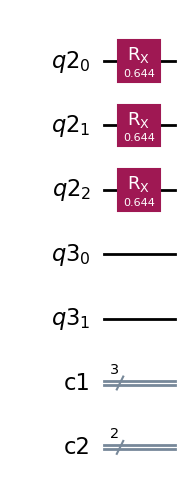

In [16]:
# Add some errors as defined above (only add errors to the encoding qubits)
def make_some_noise(qc, encoding, syndrome, error_percentage):
    encoding_q0, encoding_q1, encoding_q2 = encoding
    syndrome_b0, syndrome_b1 = syndrome

    ####### your code goes here #######
    theta = math.asin(math.sqrt(error_percentage / 100)) * 2

    qc.rx(theta, encoding_q0)
    qc.rx(theta, encoding_q1)
    qc.rx(theta, encoding_q2)

    return qc


# Constructing a circuit with 10% error rate (for each of the encoding qubit)
noise_circuit = make_some_noise(initialize_circuit(), encoding, syndrome, 10)
noise_circuit.draw(output="mpl")

```{admonition} 解説
:class: tip
前のExerciseは、任意のエラー率を挿入する回路を作成するのですが、この時も量子ビットの性質を利用します。

問題文に条件が書いてあるので順に整理します。

- エラーが発生する確率を選択できるようにしたい。

こちらはすでに問題の中で実装済みで、関数の引数である error_percentage がその確率にあたります。

- 入力はパーセンテージで、出力はその確率でエラーを発生させる回路にしたい。

ここで入力はパーセンテージといわれているので error_percentage の単位は%であることが分かります。
そしてこの関数によって回路に error_percentage (%)のエラーが生じなければなりません。

- 3エンコード量子ビットのエラーが互いに独立であるようにしたい。

このことから、エラーはエンコード量子ビットに対して個々に実施することになります。(エンコードした時のようにcxゲートなどを使ってエラーを伝搬させたりしない)

- 修正対象であるビット反転エラーを導入したい。

これがこの問題の核となる部分です。
ビット反転エラーはつまり「0」を「1」と間違って読み出すエラーなので、「10%の確率でビット反転エラーを発生させるエラー」と言われたら、random関数などを用いて1/10の割合で対象のビットにxゲートを適応する以下のようなコードを思いつくかもしれません。

~~~
if(random.random() <= 0.1){
	qc.x(encoding_q0)
}
~~~

しかしこれは誤りです。というのもこれは確かに1/10でビットが反転はしていますが、エンコード量子ビットを測定するときのエラー率は変化していないためです。
(言い方を変えると、ビットは1/10で反転しているかもしれませんが、他にエラーがない場合そのビットの測定時は常に一方の値で測定されてしまいます。)

エラー率を挿入するということは、測定時に「0」となるはずがエラーが発生して「1」となる状態にする必要があります。
これを考えるにはブロッホ球で考えるのが良いと思います。ブロッホ球のイメージは[ジェームズさんのサイト](https://javafxpert.github.io/grok-bloch/)から引用いたします。

まず「0」の状態であるブロッホ球は以下のようになり、これは測定すると測定誤差などが無いとした場合は常に「0」となります。


![ブロッホ球1](resources/2023-spring-bloch-sphere1.png)

次にアダマールゲートを適用した場合を考えてみると、この時ブロッホ球は以下のようになり、「0」と「1」は半々の確率で測定されるようになります。

![ブロッホ球2](resources/2023-spring-bloch-sphere2.png)

このように「0」と「1」の間を指すようにすれば、その割合で測定誤差が生じることになります。
これを整理すると、以下のような位置を指すことができればいいということになります。

![ブロッホ球3](resources/2023-spring-bloch-sphere3.png)

この時回転の中心は、Z軸（状態「0」と「1」を結ぶ軸）に垂直であれば良いので、解説ではX軸を中心として指定する角度だけ回転させるrxゲートを適用します。

rxゲートによって $ \theta $ だけ回転するときの、 $ \ket{0} $ と $ \ket{1} $ の確率の変化を求めます。rxゲートによる回転角が $ \theta $ とき、rxゲートは次のような式で表されます。

$$ 
Rx(\theta) = \begin{pmatrix}
\cos{(\theta/2)} & -i\sin{(\theta/2)} \\
-i\sin{(\theta/2)} & \cos{(\theta/2)} \\
\end{pmatrix} 
$$

このrxゲートを$ \ket{0} $ 、 $ \ket{1} $ にそれぞれ適用すると以下の式のようになります。

$$
Rx(\theta)\ket{0} = \begin{pmatrix}
\cos{(\theta/2)} & -i\sin{(\theta/2)} \\
-i\sin{(\theta/2)} & \cos{(\theta/2)} \\
\end{pmatrix} 
\begin{pmatrix}
1 \\
0 \\
\end{pmatrix} 
= \begin{pmatrix}
\cos{(\theta/2)} \\
-i\sin{(\theta/2)} \\
\end{pmatrix} 
= \cos{(\theta/2)}\ket{0} - i\sin{(\theta/2)}\ket{1}
$$

$$
Rx(\theta)\ket{1} = \cos{(\theta/2)}\ket{1} - i\sin{(\theta/2)}\ket{0}
$$

つまりrxゲートを適用することで、 $ (\sin{(\theta/2)})^2 $ の確率だけ元の量子ビットとは逆の情報が現れることになります。

この確率を、エラーの確率と等しくする必要があるので、Z軸からの回転角 $ \theta $ は

$$ error\_percentage/100 = (\sin{(\theta/2)})^2 $$
$$ \theta = 2 \times \arcsin{(\sqrt{error\_percentage/100})} $$

以上でエラーパーセンテージ $ error\_percentage $ を発生させる回転角 $ \theta $ が求まったため、これを3エンコード量子ビットそれぞれに適用（rxゲートを回転角 $ \theta $ 適用）すれば、目標を達成することができます。
```

10％の確率でエラーを導入した場合、エラー訂正がどれだけうまく動くか検証します。

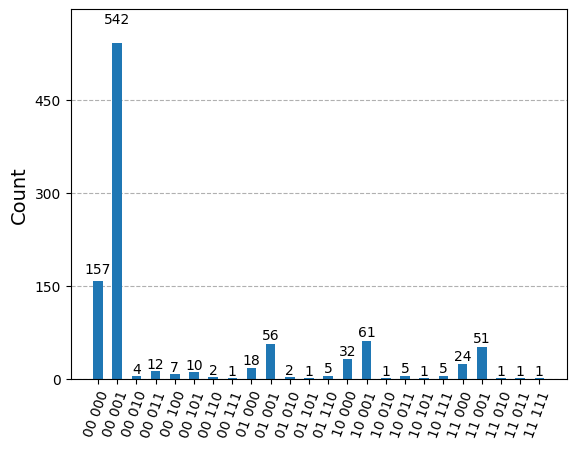

In [17]:
qc4 = (
    initial_state.compose(encoding_circuit)
    .compose(noise_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)


# We choose again FakeManila
backend = FakeManilaV2()
# let the simulation run
counts = backend.run(qc4, shots=1000).result().get_counts()
# and plot our results
plot_histogram(counts)

結果は悪化してしまいましたが、ほとんどの場合、`001`が取得出来ていることが分かります。

これで、最初の誤り訂正符号を作成し、テストすることに成功しました。  
もし位相エラーも補正したいのであれば、別の方式とより多くの量子ビットが必要です。

## 補足: エラー訂正とハードウェアレイアウト

ここまではハードウェアのシミュレーターを使用しましたが、実機でより複雑なものを実行したい場合は、量子ビットのレイアウトも考慮する必要があります。  
デバイスのレイアウトは重要です。実機ではすべての量子ビットが互いに接続されている理想的な状態ではないので、レイアウトを考えなければ、3つの CX 演算で構成される SWAP 演算が大量に使われることになります。  
もちろん、エラーも発生します。

例えば次のような物理量子ビットのレイアウトがあるとします。

    0 - 1 - 2 - 3 - 4 

この物理量子ビットを、エラー訂正回路で使用した論理量子ビットにどのようにマッピングするのでしょうか？  
ここでは、量子ビットの最初のエンタングルメント部分の接続は、エラー訂正部分よりも「簡単」だと仮定します。  
エラー訂正部分は何度か繰り返したいので、エラー訂正部分のみを考えて、これらの量子ビットをどのようにマッピングするのでしょうか？

以下のコードで、レイアウトの違いで異なる回路になることを確認できます。

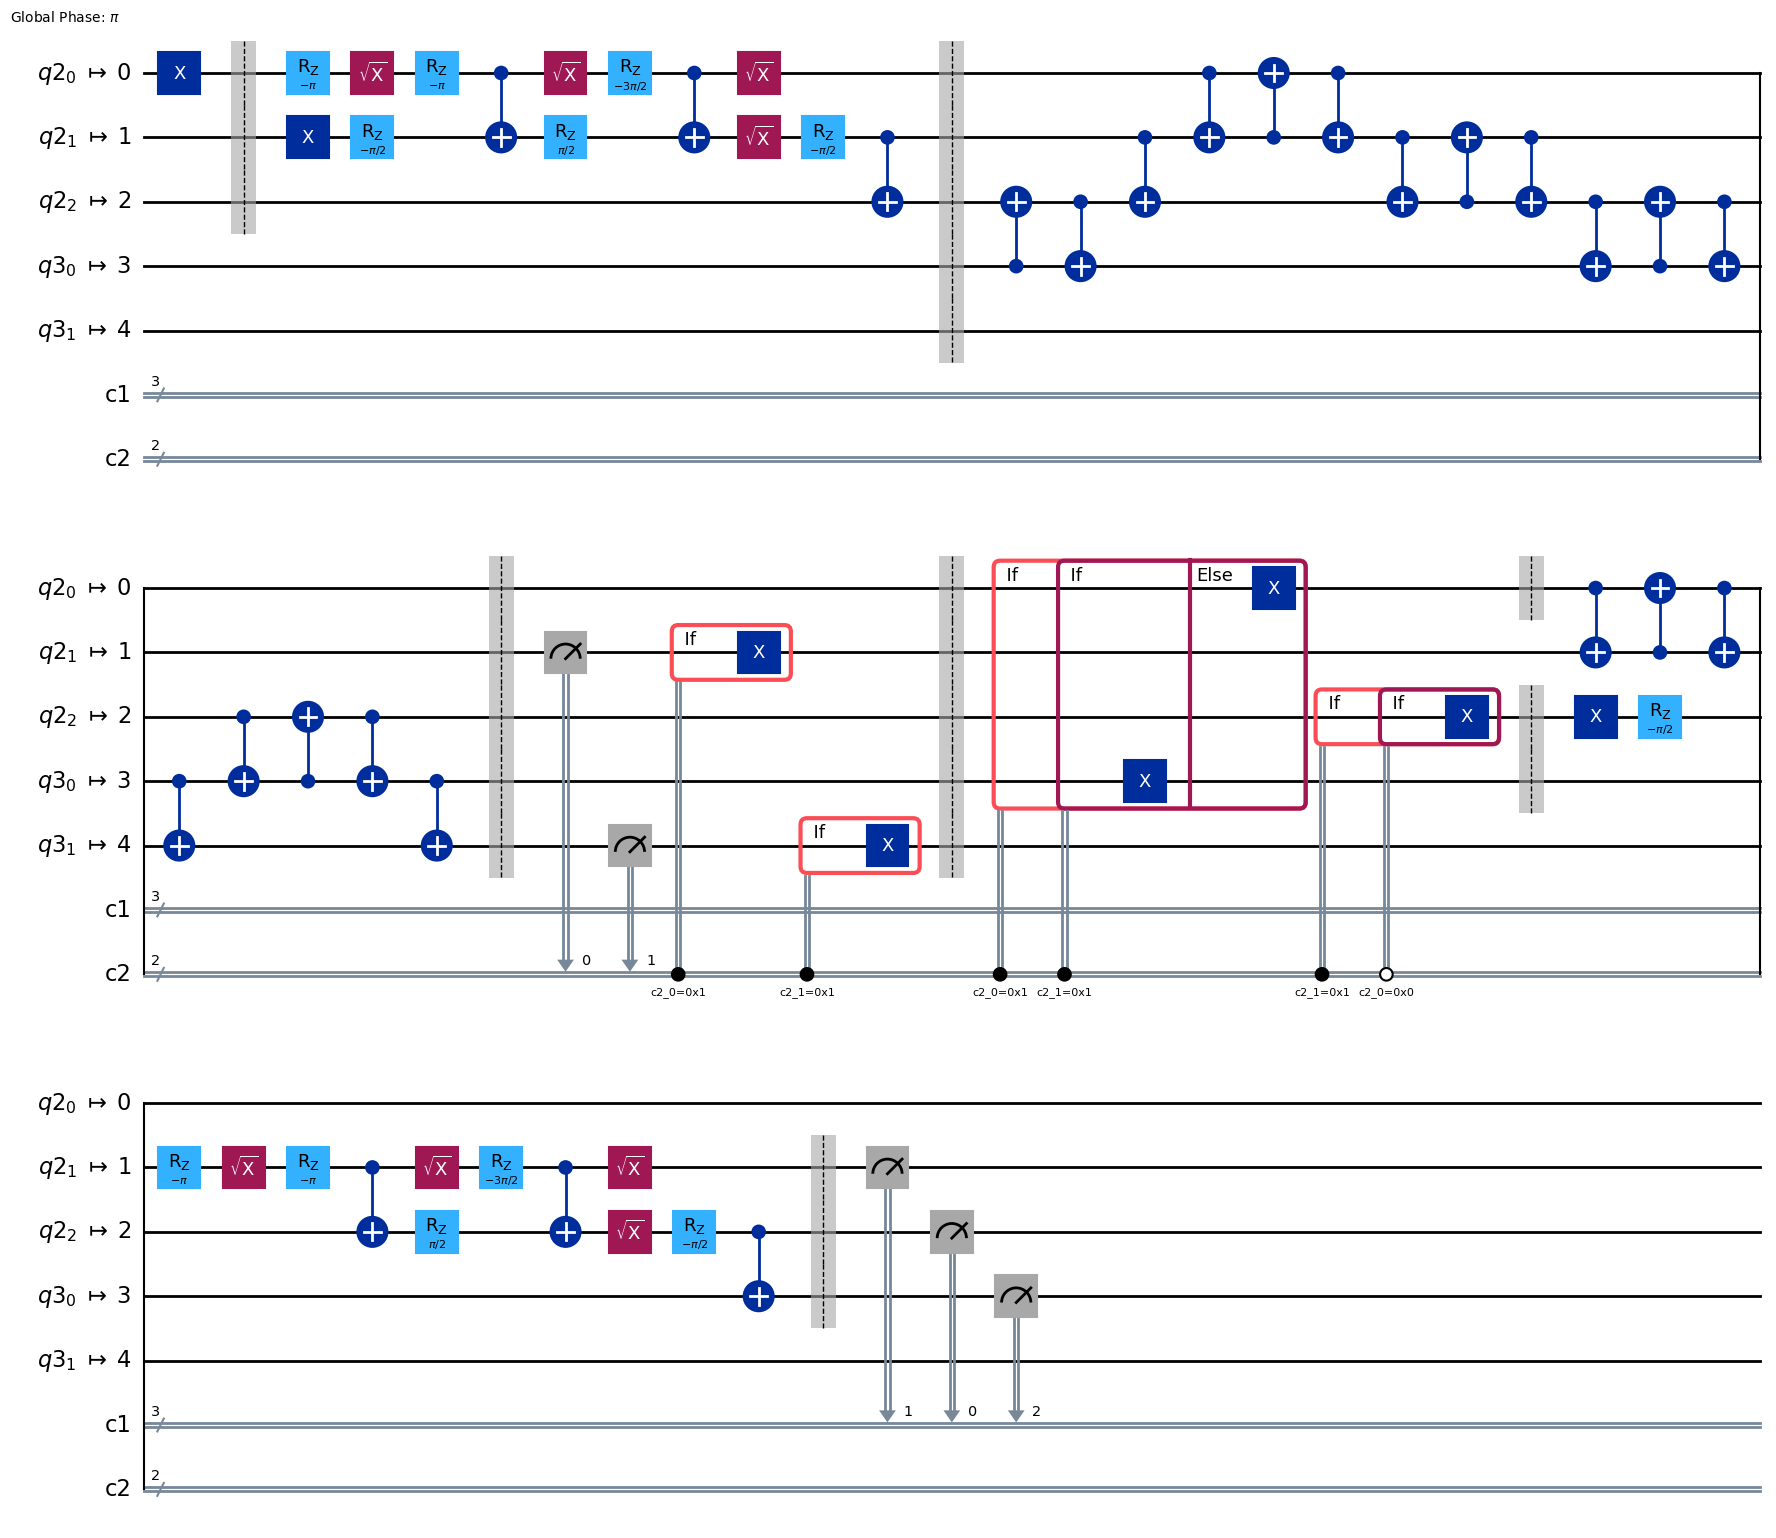

In [18]:
from qiskit.circuit import IfElseOp

# Fill in a better layout to test!!
initial_layout = [0, 1, 2, 3, 4]

# We use Manila as our potential backend, since it has the wanted layout
backend = FakeManilaV2()

# Temporary workaround for fake backends. For real backends this is not required.
backend.target.add_instruction(IfElseOp, name="if_else")

# And now we transpile the circuit for the backend.
qc_transpiled = transpile(complete_circuit, backend, initial_layout=initial_layout)

qc_transpiled.draw("mpl")

完璧なレイアウトはありません。特に、最初の部分は3つの量子ビットをエンタングルさせるために、エラー訂正部分とは異なる接続が必要です。

[0, 4, 2, 1, 3]というレイアウトは、エラー訂正に必要なすべてのCXゲートを直接接続することができ、その部分は何度も実行される可能性があるため、理にかなっています。  
また、回路を構成するために最初にスタビライザーとして使用される量子ビットを使用することができるので、これらの量子ビットで初期設定（エンタングル）をどのようにうまく行うことができるかを考える余地もあります。

レイアウトによって結果がかなり異なることを示すために、次のレイアウトを見てみましょう。どのように量子ビットをマッピングするのでしょうか？


    2 - 3 - 4 
            |
           15
            |
           22

上記と同様に[2, 4, 22, 3, 15]のレイアウトが理にかなっていると言えるでしょう。必要なCXゲートをすべて直接接続することができるからです。  
どちらのレイアウトも単純な線であるため、これらのレイアウト間に差異はないことがわかります。しかし、実際のバックエンドを見ると、他の5量子ビットデバイスもあることがわかります。Manilaを選んだのは、exerciseに適していたからです。

これらのシンプルな例から実際のハードウェアでは量子ビットのレイアウトに注意しなければならないことがわかります。